## Sweeping over a paramter range in HFSS 🧹

Analyzing the cavity is nice and all, but it very likely that you'll want to modify and optimize the cavity and it's properties for your needs. For this you can
simulate many different possibilities and choose the best paramters for you.

Let's say, for example, you want the coupling between the readout resonator and transmon would be around $1$ MHz, what should be the distance between them? Let's check!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyEPR as epr

plt.style.use('ggplot')
plt.style.use('seaborn-darkgrid')

#### 🔹 Connecting to HFSS

In [2]:
pinfo = epr.Project_Info(project_path = '.', 
                         project_name = 'DesignSimulations',  # File name
                         design_name  = 'TabChipPenetration')

INFO 03:52PM [connect]: Connecting to Ansys Desktop API...
INFO 03:52PM [load_ansys_project]: 	File path to HFSS project found.
INFO 03:52PM [load_ansys_project]: 	Opened Ansys App
INFO 03:52PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 03:52PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    E:/CavityLocalSimulations/
	Project:   DesignSimulations
INFO 03:52PM [connect]: 	Opened active design
	Design:    TabChipPenetration [Solution type: Eigenmode]
INFO 03:52PM [get_setup]: 	Opened setup `Setup1`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 03:52PM [connect]: 	Connection to Ansys established successfully. 😀 



#### 🧹 Sweep over the parameter

In [3]:
chip_penetration = pinfo.project.get_variable_value('$chip_penetration')
print(chip_penetration)

0.2mm


In [4]:
%%time
swp_var = '$chip_penetration'  # Sweep over '$chip_penetration'

def to_swp_val(x): return f'{x}mm' 


num_variations = 5
for swp_param in np.linspace(0.0, 0.2, num_variations):
    swp_val = to_swp_val(swp_param)
    epr.logger.info(f'Setting sweep variable {swp_var}={swp_val}')
    pinfo.project.set_variable(swp_var, swp_val)
    pinfo.setup.analyze()

INFO 03:52PM [<module>]: Setting sweep variable $chip_penetration=0.0mm
INFO 03:52PM [analyze]: Analyzing setup Setup1
INFO 03:52PM [<module>]: Setting sweep variable $chip_penetration=0.05mm
INFO 03:52PM [analyze]: Analyzing setup Setup1
INFO 03:52PM [<module>]: Setting sweep variable $chip_penetration=0.1mm
INFO 03:52PM [analyze]: Analyzing setup Setup1
INFO 03:53PM [<module>]: Setting sweep variable $chip_penetration=0.15000000000000002mm
INFO 03:53PM [analyze]: Analyzing setup Setup1
INFO 03:53PM [<module>]: Setting sweep variable $chip_penetration=0.2mm
INFO 03:53PM [analyze]: Analyzing setup Setup1
Wall time: 31.4 s


#### 🔹 Define the junction (and any other non-linear component)

In [5]:
pinfo.junctions['j1'] = {'Lj_variable' : '$Lj',
                         'rect'        : 'rect_jj1', 
                         'line'        : 'line_jj1', 
                         'length'      : epr.parse_units('100um')}

# Check that valid names of variables and objects have been supplied.
# An error is raised with a message if something is wrong.
pinfo.validate_junction_info()

#### 🔹 Distributed Analysis (not quantum)

Note that **3 modes is the maximum we can analyze fully❗** See [this issue][issue]

The relevant modes we look into are 1 (cavity), 2 (transmon) and 5 (readout resonator).

[issue]: https://github.com/zlatko-minev/pyEPR/issues/36

In [6]:
eprh = epr.DistributedAnalysis(pinfo)


Design "TabChipPenetration" info:
	# eigenmodes    7
	# variations    5


In [7]:
%%time
eprh.do_EPR_analysis(modes=[0,1,4])



Variation 0  [1/5]

  Mode 0 at 4.37 GHz   [1/7]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.0%   1.32e-19  1.32e-19

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.95%
	j1              3.27333e-05  (+)        3.45881e-07
		(U_tot_cap-U_tot_ind)/mean=0.02%

  Mode 1 at 5.21 GHz   [2/7]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               93.4%  3.322e-24 2.196e-25

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.52%
	j1              0.931853  (+)        0.0139553
		(U_tot_cap-U_tot_ind)/mean=0.80%

  Mode 4 at 6.62 GHz   [5/7]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H


(WindowsPath('E:/data-pyEPR/DesignSimulations/TabChipPenetration/2021-04-12 15-53-16.npz'),
 ['0', '1', '2', '3', '4'])

#### 🔹 Quantum Analysis (yes quantum)

In [8]:
%%time
epra = epr.QuantumAnalysis(eprh.data_filename)
epra.analyze_all_variations(cos_trunc = 8, fock_trunc = 15);

	 Differences in variations:


variation,0,1,2,3,4
_$chip_penetration,0mm,0.050000000000000003mm,0.10000000000000001mm,0.15000000000000002mm,0.20000000000000001mm





 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    6.580011
1    1.016626
4    1.166611
dtype: float64

Pm_norm idx =
      j1
0  False
1   True
4  False

*** Different parameters


_$chip_penetration    0mm
Name: 0, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.000033
1  0.919027
4  0.033480

*** S (sign-bit matrix)
   s_j1
0     1
1     1
4     1
*** P (participation matrix, normalized.)
   3.3e-05
      0.93
     0.033

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
   1.1e-07  0.00745  0.00034
   0.00745      127     11.5
   0.00034     11.5    0.263

*** Chi matrix ND (MHz) 
   2.7e-07   0.0144 0.000378
    0.0144      138     9.44
  0.000378     9.44    0.183

*** Frequencies O1 PT (MHz)
0    4372.447007
1    5072.987608
2    6616.830156
dtype: float64

*** Frequencies ND (MHz)
0    4372.446101
1    5068.826981
2    6617.211977
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1, 4]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 1

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    6.005015
1    1.016367
4    1.182691
dtype: float64

Pm_norm idx =
   

_$chip_penetration    0.050000000000000003mm
Name: 1, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.000043
1  0.919917
4  0.032216

*** S (sign-bit matrix)
   s_j1
0     1
1     1
4     1
*** P (participation matrix, normalized.)
   4.3e-05
      0.93
     0.032

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
  1.85e-07  0.00962 0.000425
   0.00962      125       11
  0.000425       11    0.243

*** Chi matrix ND (MHz) 
  4.71e-07   0.0191 0.000488
    0.0191      136     9.09
  0.000488     9.09    0.172

*** Frequencies O1 PT (MHz)
0    4372.418953
1    5034.337906
2    6611.026115
dtype: float64

*** Frequencies ND (MHz)
0    4372.417744
1    5030.315545
2    6611.372769
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1, 4]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 2

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    5.688584
1    1.017339
4    1.181551
dtype: float64

Pm_norm idx =
   

_$chip_penetration    0.10000000000000001mm
Name: 2, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.000042
1  0.920847
4  0.031330

*** S (sign-bit matrix)
   s_j1
0     1
1     1
4     1
*** P (participation matrix, normalized.)
   4.2e-05
      0.94
     0.031

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
  1.84e-07   0.0096 0.000412
    0.0096      125     10.7
  0.000412     10.7     0.23

*** Chi matrix ND (MHz) 
  4.69e-07   0.0191 0.000473
    0.0191      136     8.85
  0.000473     8.85    0.162

*** Frequencies O1 PT (MHz)
0    4372.355224
1    5032.590998
2    6609.326205
dtype: float64

*** Frequencies ND (MHz)
0    4372.354015
1    5028.564225
2    6609.664055
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1, 4]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 3

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    5.004736
1    1.015911
4    1.180812
dtype: float64

Pm_norm idx =
   

_$chip_penetration    0.15000000000000002mm
Name: 3, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.000053
1  0.925634
4  0.028678

*** S (sign-bit matrix)
   s_j1
0     1
1     1
4     1
*** P (participation matrix, normalized.)
   5.3e-05
      0.94
     0.029

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
  2.82e-07   0.0118 0.000467
    0.0118      124     9.79
  0.000467     9.79    0.193

*** Chi matrix ND (MHz) 
  7.48e-07   0.0242 0.000556
    0.0242      135     8.14
  0.000556     8.14    0.139

*** Frequencies O1 PT (MHz)
0    4372.336603
1    4993.535931
2    6615.679886
dtype: float64

*** Frequencies ND (MHz)
0    4372.335054
1    4989.632084
2    6615.970468
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1, 4]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 4

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    4.621644
1    1.017324
4    1.175574
dtype: float64

Pm_norm idx =
   

_$chip_penetration    0.20000000000000001mm
Name: 4, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.000052
1  0.920612
4  0.031464

*** S (sign-bit matrix)
   s_j1
0     1
1     1
4     1
*** P (participation matrix, normalized.)
   5.2e-05
      0.94
     0.031

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
  2.74e-07   0.0117 0.000504
    0.0117      125     10.8
  0.000504     10.8    0.232

*** Chi matrix ND (MHz) 
  6.97e-07   0.0232 0.000577
    0.0232      136     8.87
  0.000577     8.87    0.163

*** Frequencies O1 PT (MHz)
0    4372.398709
1    5034.498457
2    6603.922985
dtype: float64

*** Frequencies ND (MHz)
0    4372.397236
1    5030.466264
2    6604.264537
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1, 4]
Wall time: 1min 44s


OrderedDict([('0',
              OrderedDict([('f_0', 0    4372.450904
                            1    5205.376147
                            2    6491.767083
                            3    6493.924437
                            4    6622.865974
                            5    7763.404010
                            6    7763.572012
                            Name: 0, dtype: float64),
                           ('f_1',
                            0    4372.447007
                            1    5072.987608
                            2    6616.830156
                            dtype: float64),
                           ('f_ND',
                            0    4372.446101
                            1    5068.826981
                            2    6617.211977
                            dtype: float64),
                           ('chi_O1',
                                          0           1          2
                            0  1.096532e-07    0.007452   0.000340
  

### Does this make sense?🤔

We can plot the results and see weather or not they make sense. We expect:

Note that the anharmonicities of the cavity and the readout resonator are many orders of magnitude smaller that that of the transmon.
X markers indicate the non-primary results (chi01, first order Phase Transition) and O markers+grey lines indicate the primary results (numerically diagonalized, chiND).



(<Figure size 720x432 with 4 Axes>,
 array([[<AxesSubplot:title={'center':'Modal frequencies (MHz)'}, xlabel='$chip_penetration'>,
         <AxesSubplot:title={'center':'Anharmonicities (MHz)'}, xlabel='$chip_penetration'>],
        [<AxesSubplot:title={'center':'Quality factors'}, xlabel='$chip_penetration'>,
         <AxesSubplot:title={'center':'Cross-Kerr frequencies (MHz)'}, xlabel='$chip_penetration'>]],
       dtype=object))

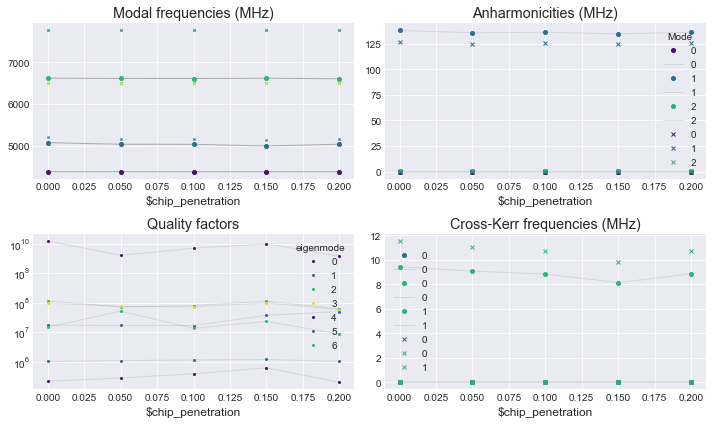

In [9]:

epra.plot_hamiltonian_results(swp_variable=swp_var)

We can see the change in the cavity-transmon coupling according to the chip penetration depth.

In [10]:
epra.report_results(swp_variable=swp_var, numeric=True)

#### Mode frequencies (MHz)

###### Numerical diagonalization

$chip_penetration,0.00,0.05,0.10,0.15,0.20
eigenmode,,,,,
0,4372.45,4372.42,4372.36,4372.34,4372.40
1,5072.99,5034.34,5032.59,4993.54,5034.50
2,6616.83,6611.03,6609.33,6615.68,6603.92


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0       1         2
$chip_penetration                              
0.00              0  2.70e-07    0.01  3.78e-04
                  1  1.44e-02  137.82  9.44e+00
                  2  3.78e-04    9.44  1.83e-01
0.05              0  4.71e-07    0.02  4.88e-04
                  1  1.91e-02  135.59  9.09e+00
                  2  4.88e-04    9.09  1.72e-01
0.10              0  4.69e-07    0.02  4.73e-04
                  1  1.91e-02  135.99  8.85e+00
                  2  4.73e-04    8.85  1.62e-01
0.15              0  7.48e-07    0.02  5.56e-04
                  1  2.42e-02  134.53  8.14e+00
                  2  5.56e-04    8.14  1.39e-01
0.20              0  6.97e-07    0.02  5.77e-04
                  1  2.32e-02  136.04  8.87e+00
                  2  5.77e-04    8.87  1.63e-01

## Success 🎉🎈🎊🥳💃